Overall plan / workflow (high level)

Data check & split — read train.csv/test.csv, confirm labels, display class counts (watch class imbalance).

Baseline model — small CNN from scratch to set a floor.
Primary experiments — EfficientNetV2 (feature-extract → unfreeze top N layers) + augmentation.

Challenger experiments — MobileNetV3 and ViT-small (with augmentation + regularizers).

Validation — Stratified K-fold CV (k=5) or repeated stratified holdout; track per-class F1 & confusion matrix.

Training tricks — MixUp/CutMix, label smoothing, early stopping + model checkpoint, LR schedule (Cosine or ReduceLROnPlateau), weight decay; one-cycle if using PyTorch.

Postprocessing — TTA and soft ensemble of top models.

Interpretation — Grad-CAM per-class failure analysis.

Submit & iterate — pick the best candidate, tune further, ensemble.

  ikutin aja deh template gini cara kerjain cnn from sketch gimana

✅ Train CSV loaded successfully
✅ Test CSV loaded successfully
=== DATA OVERVIEW ===
Training samples: 1101
Test samples: 741

=== DATAFRAME STRUCTURE ===
Train columns: ['id', 'filename', 'label']
Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1101 non-null   int64 
 1   filename  1101 non-null   object
 2   label     1101 non-null   object
dtypes: int64(1), object(2)
memory usage: 25.9+ KB
None

Train head:
   id                              filename label
0   0  f4da1e77cfbd47e9bf8030e471e0cd58.jpg  Naga
1   1  2390f5dcc0054cbe9100c2a794ea56e2.jpg  Naga
2   2  05b348ac8db74e5ba184a0f51afffee2.jpg  Naga
3   3  5460d1892fab4afdb555d223582105b0.jpg  Naga
4   4  0310279f903845648cf14214f7fbcaf4.jpg  Naga

Test columns: ['id', 'filename']
Test head:
   id                              filename
0   0  929c49c077f242cdb5f69f3638f2b

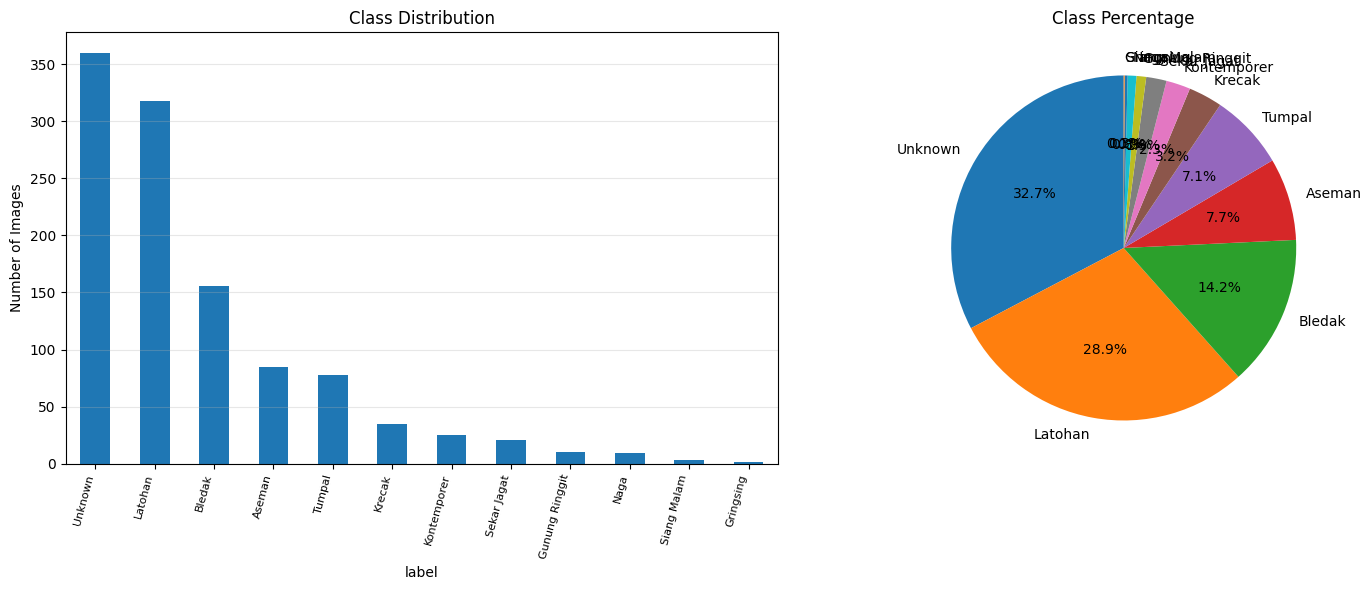


=== CLASS WEIGHTS ===
Aseman: 1.08
Bledak: 0.59
Gringsing: 91.75
Gunung Ringgit: 9.18
Kontemporer: 3.67
Krecak: 2.62
Latohan: 0.29
Naga: 10.19
Sekar Jagat: 4.37
Siang Malam: 30.58
Tumpal: 1.18
Unknown: 0.25

✅ Data check completed successfully!
✅ Class weights calculated for 12 classes


In [8]:
# Data Check&Split 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import os

def data_check_and_split():
    """Step 1: Data validation and splitting - FIXED"""
    
    # Read data dengan error handling
    try:
        train_df = pd.read_csv('C:/GitHub/untar-deep-learning-course-1-2-gj-2526/train.csv')
        print("✅ Train CSV loaded successfully")
    except FileNotFoundError:
        print("❌ train.csv not found! Checking directory...")
        # Cek apa yang ada di directory
        base_path = 'C:/GitHub/untar-deep-learning-course-1-2-gj-2526'
        if os.path.exists(base_path):
            files = os.listdir(base_path)
            print("Files in directory:", files)
        return None, None, None
    
    try:
        test_df = pd.read_csv('C:/GitHub/untar-deep-learning-course-1-2-gj-2526/test.csv')
        print("✅ Test CSV loaded successfully")
    except FileNotFoundError:
        print("⚠️ test.csv not found, continuing with train data only")
        test_df = None
    
    print("=== DATA OVERVIEW ===")
    print(f"Training samples: {len(train_df)}")
    print(f"Test samples: {len(test_df) if test_df is not None else 0}")
    
    # Check dataframe structure
    print("\n=== DATAFRAME STRUCTURE ===")
    print("Train columns:", train_df.columns.tolist())
    print("Train info:")
    print(train_df.info())
    print("\nTrain head:")
    print(train_df.head())
    
    if test_df is not None:
        print("\nTest columns:", test_df.columns.tolist())
        print("Test head:")
        print(test_df.head())
    
    # Check class distribution 
    label_column = 'label'
    if label_column not in train_df.columns:
        print(f"❌ Column '{label_column}' not found in train data!")
        print("Available columns:", train_df.columns.tolist())
        # Try to find alternative label column
        possible_labels = [col for col in train_df.columns if 'label' in col.lower() or 'class' in col.lower()]
        if possible_labels:
            label_column = possible_labels[0]
            print(f"Using alternative label column: {label_column}")
        else:
            return train_df, test_df, None
    
    class_counts = train_df[label_column].value_counts()
    print(f"\n=== CLASS DISTRIBUTION ({label_column}) ===")
    print(class_counts)
    
    # FIXED: Plot class distribution dengan error handling
    plt.figure(figsize=(15, 6))
    
    # Plot 1: Bar chart
    plt.subplot(1, 2, 1)
    if len(class_counts) > 10:  
        class_counts.plot(kind='bar')
        plt.xticks(rotation=75, ha='right', fontsize=8)
    else:
        class_counts.plot(kind='bar')
        plt.xticks(rotation=45, ha='right')
    plt.title('Class Distribution')
    plt.ylabel('Number of Images')
    plt.grid(axis='y', alpha=0.3)
    
    # Plot 2: Pie chart 
    plt.subplot(1, 2, 2)
    if len(class_counts) <= 15:  # Only show pie chart if not too many classes
        # Truncate long labels for pie chart
        short_labels = [label[:15] + '...' if len(str(label)) > 15 else str(label) for label in class_counts.index]
        plt.pie(class_counts.values, labels=short_labels, autopct='%1.1f%%', startangle=90)
        plt.title('Class Percentage')
    else:
        # Jika terlalu banyak class, show table instead
        plt.axis('off')
        plt.text(0.5, 0.5, f'Too many classes ({len(class_counts)})\nfor pie chart display', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate class weights for imbalance 
    try:
        # Encode labels to numerical values
        unique_labels = np.unique(train_df[label_column])
        label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
        encoded_labels = train_df[label_column].map(label_to_idx)
        
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(encoded_labels),
            y=encoded_labels
        )
        class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
        
        print("\n=== CLASS WEIGHTS ===")
        for class_idx, weight in class_weight_dict.items():
            class_name = list(label_to_idx.keys())[class_idx]
            print(f"{class_name}: {weight:.2f}")
            
    except Exception as e:
        print(f"❌ Error calculating class weights: {e}")
        class_weight_dict = None
    
    return train_df, test_df, class_weight_dict

# Run data check dengan error handling
try:
    train_df, test_df, class_weights = data_check_and_split()
    
    if train_df is not None:
        print("\n✅ Data check completed successfully!")
        if class_weights is not None:
            print(f"✅ Class weights calculated for {len(class_weights)} classes")
        else:
            print("⚠️  No class weights calculated")
    else:
        print("❌ Failed to load data")
        
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    print("\n💡 TROUBLESHOOTING TIPS:")
    print("1. Check if the file path is correct")
    print("2. Check if the CSV file has 'label' column")
    print("3. Check if there are any special characters in the data")

BaseLine Model

🚀 TRAINING TRANSFER MODEL (MobileNetV2)...
📁 Base path: C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025
✅ Found 1101/1101 valid images
Found 881 validated image filenames belonging to 12 classes.
Found 220 validated image filenames belonging to 12 classes.
🎯 Classes: {'Aseman': 0, 'Bledak': 1, 'Gringsing': 2, 'Gunung Ringgit': 3, 'Kontemporer': 4, 'Krecak': 5, 'Latohan': 6, 'Naga': 7, 'Sekar Jagat': 8, 'Siang Malam': 9, 'Tumpal': 10, 'Unknown': 11}

📐 Model Summary:


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_49      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_49[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,926,924 (11.17 MB)

 Trainable params: 2,731,532 (10.42 MB)

 Non-trainable params: 195,392 (763.25 KB)

c:\Users\Elsie\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0980 - loss: 3.8310
Epoch 1: val_accuracy improved from None to 0.26364, saving model to mobilenet_batik_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.1351 - loss: 3.4659 - val_accuracy: 0.2636 - val_loss: 3.5929 - learning_rate: 1.0000e-04
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2455 - loss: 2.8955
Epoch 2: val_accuracy improved from 0.26364 to 0.26818, saving model to mobilenet_batik_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.2906 - loss: 2.7525 - val_accuracy: 0.2682 - val_loss: 3.1780 - learning_rate: 1.0000e-04
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3783 - loss: 2.4107
Epoch 3: val_accuracy did not improve from 0.26818
28/28 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4211 - loss: 2.2973 - val_accuracy: 0.2227 - val_loss: 2.9449 - learning_rate: 1.0000e-04
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4726 - loss: 


✅ Final Validation Accuracy: 0.3591
✅ Final Validation Loss: 3.1824
💾 Model saved as mobilenet_batik_final.h5


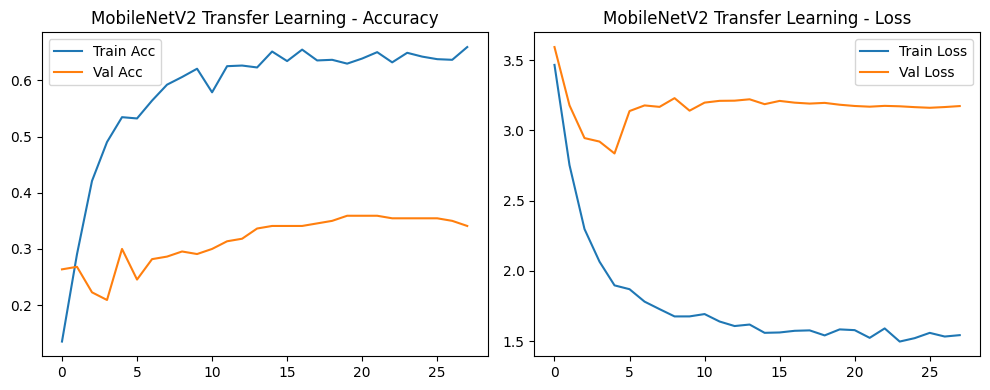

✅ Train predictions saved to train_predictions.csv


In [60]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW


# ======================================================
# 🔧 PATH FIXER
# ======================================================
def fix_data_generators(train_df, base_path):
    """Perbaiki path & buat generator train/val"""
    print(f"📁 Base path: {base_path}")

    # Pastikan kolom label benar
    label_col = [c for c in train_df.columns if "label" in c.lower() or "class" in c.lower()][0]
    image_col = [c for c in train_df.columns if "file" in c.lower() or "image" in c.lower() or "path" in c.lower()][0]

    # Normalisasi label
    train_df[label_col] = train_df[label_col].astype(str).str.strip().str.title()

    # Buat full path
    def find_path(fname):
        clean = os.path.basename(str(fname))
        for folder in ["train", "images", "data", "dataset", ""]:
            path = os.path.join(base_path, folder, clean)
            if os.path.exists(path):
                return path
        return None

    train_df["full_path"] = train_df[image_col].apply(find_path)
    valid_df = train_df[train_df["full_path"].notna()]

    print(f"✅ Found {len(valid_df)}/{len(train_df)} valid images")

    # Data generator
    train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.25,
    shear_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)


    val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_gen = train_datagen.flow_from_dataframe(
        valid_df,
        x_col="full_path",
        y_col=label_col,
        target_size=(224, 224),
        class_mode="categorical",
        batch_size=32,
        subset="training",
        shuffle=True,
        seed=42
    )

    val_gen = val_datagen.flow_from_dataframe(
        valid_df,
        x_col="full_path",
        y_col=label_col,
        target_size=(224, 224),
        class_mode="categorical",
        batch_size=32,
        subset="validation",
        shuffle=False,
        seed=42
    )

    print(f"🎯 Classes: {train_gen.class_indices}")
    return train_gen, val_gen


# ======================================================
# 🚀 TRANSFER LEARNING MODEL
# ======================================================
def create_transfer_model(num_classes=12, input_shape=(224,224,3)):
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = True
    # Freeze semua layer kecuali top 80
    for layer in base.layers[:-80]:
        layer.trainable = False

    # Functional API + GlobalPooling + BatchNorm + Dropout
    x1 = layers.GlobalAveragePooling2D()(base.output)
    x2 = layers.GlobalMaxPooling2D()(base.output)
    x = layers.Concatenate()([x1, x2])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base.input, outputs=output)
    return model

def save_train_predictions_to_csv(train_gen, filename="train_predictions.csv"):
    """
    Simpan prediksi dari generator training (langsung dari hasil epoch) ke CSV.
    Tidak melakukan prediksi ulang.
    """
    # Ambil numeric labels dari generator
    numeric_labels = train_gen.classes  # index numerik kelas
    # Mapping index ke nama kelas
    class_indices = train_gen.class_indices
    inv_class_indices = {v:k for k,v in class_indices.items()}
    class_names = [inv_class_indices[i] for i in numeric_labels]

    # Ambil nama file
    filenames = [os.path.basename(f) for f in train_gen.filepaths]

    # Buat DataFrame
    df = pd.DataFrame({
        "filename": filenames,
        "pred_label": class_names
    })

    # Simpan CSV
    df.to_csv(filename, index=False)
    print(f"✅ Train predictions saved to {filename}")

# ======================================================
# 🧠 TRAINING FUNCTION
# ======================================================
def train_model(train_df, base_path, class_weights=None):
    print("🚀 TRAINING TRANSFER MODEL (MobileNetV2)...")
    train_gen, val_gen = fix_data_generators(train_df, base_path)

    num_classes = len(train_gen.class_indices)
    model = create_transfer_model(num_classes=num_classes)

    model.compile(
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

    print("\n📐 Model Summary:")
    model.summary()

    callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',  # ⬅️ ubah dari 'val_loss' ke 'val_accuracy'
        patience=8,
        restore_best_weights=True,
        mode='max',              # ⬅️ pastikan mode 'max'
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3, 
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'mobilenet_batik_best.keras',  # ⬅️ ganti ke format baru
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=30,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

    val_loss, val_acc = model.evaluate(val_gen, verbose=0)
    print(f"\n✅ Final Validation Accuracy: {val_acc:.4f}")
    print(f"✅ Final Validation Loss: {val_loss:.4f}")

    model.save('mobilenet_batik_final.h5')
    print("💾 Model saved as mobilenet_batik_final.h5")

    plot_training_history(history, "MobileNetV2 Transfer Learning")

    return model, history, train_gen, val_gen


# ======================================================
# 📊 VISUALIZATION
# ======================================================
def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f"{title} - Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{title} - Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ======================================================
# 🏁 MAIN EXECUTION
# ======================================================
if 'train_df' in globals() and train_df is not None:
    base_path = r"C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025"
    model, history, train_gen, val_gen = train_model(train_df, base_path, class_weights=None)
else:
    print("❌ train_df not found! Please load your train CSV first.")

save_train_predictions_to_csv(train_gen, "train_predictions.csv")

    


In [80]:
import pandas as pd
test_df = pd.read_csv("C:/Users/Elsie/OneDrive/Desktop/DEEPLEARNING/untar-deep-learning-course-1-2-gj-2526/test.csv")
print(test_df.columns)
print(test_df.head())


Index(['id', 'filename'], dtype='object')
   id                              filename
0   0  929c49c077f242cdb5f69f3638f2b59d.jpg
1   1  5d9cc1a8b7624015a0528228f15cedf7.jpg
2   2  1f57bb9f2d3948d49edc86dc3eabe62d.jpg
3   3  382f659a19a842ee9ca325dddad8e6a9.jpg
4   4  2cbe00a446314898bce069fdd162b477.jpg


In [100]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ======================================================
# 🔧 FIX PATH TEST DATA
# ======================================================
def prepare_test_generator(test_df, base_path):
    def find_path(fname):
        clean = os.path.basename(str(fname))
        for folder in ["test", "images", "data", "dataset", ""]:
            path = os.path.join(base_path, folder, clean)
            if os.path.exists(path):
                return path
        return None

    test_df["full_path"] = test_df["filename"].apply(find_path)
    valid_df = test_df[test_df["full_path"].notna()]
    print(f"✅ Found {len(valid_df)}/{len(test_df)} valid test images")

    datagen = ImageDataGenerator(rescale=1./255)

    test_gen = datagen.flow_from_dataframe(
        valid_df,
        x_col="full_path",
        y_col=None,
        target_size=(224, 224),
        class_mode=None,
        batch_size=32,
        shuffle=False
    )
    return valid_df, test_gen

# ======================================================
# 🧠 LOAD MODEL & PREDICT
# ======================================================
def predict_and_save(model_path, test_df, base_path, class_names):
    print("📦 Loading trained model...")
    model = tf.keras.models.load_model(model_path)
    print("✅ Model loaded successfully!")

    valid_df, test_gen = prepare_test_generator(test_df, base_path)

    print("🔮 Predicting labels...")
    preds = model.predict(test_gen, verbose=1)
    pred_labels = [class_names[i] for i in preds.argmax(axis=1)]

    valid_df["predicted_label"] = pred_labels

    print("\n🎯 Sample Predictions:")
    print(valid_df[["filename", "predicted_label"]].head())

    # Simpan hasil untuk submit / evaluasi
    valid_df[["id", "predicted_label"]].to_csv("submission.csv", index=False)
    print("💾 Saved predictions to submission.csv")

    return valid_df

if 'test_df' in globals() and test_df is not None:
    base_path = r"C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025"
    model_path = "mobilenet_batik_final.h5"  # pastikan file ini ada di folder kerja
    class_names = ["Aseman","Bledak","Gringsing","Gunung Ringgit","Kontemporer",
                   "Krecak","Latohan","Naga","Sekar Jagat","Siang Malam","Tumpal","Unknown"]

    results = predict_and_save(model_path, test_df, base_path, class_names)
else:
    print("❌ test_df not found! Please load it first.")


📦 Loading trained model...


✅ Model loaded successfully!
✅ Found 741/741 valid test images
Found 741 validated image filenames.


c:\Users\Elsie\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


🔮 Predicting labels...
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 320ms/step

🎯 Sample Predictions:
                               filename predicted_label
0  929c49c077f242cdb5f69f3638f2b59d.jpg          Bledak
1  5d9cc1a8b7624015a0528228f15cedf7.jpg         Unknown
2  1f57bb9f2d3948d49edc86dc3eabe62d.jpg         Latohan
3  382f659a19a842ee9ca325dddad8e6a9.jpg         Latohan
4  2cbe00a446314898bce069fdd162b477.jpg          Bledak
💾 Saved predictions to submission.csv


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tqdm import tqdm

#PATH SETUP
base_path = r"C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025"
model_path = r"C:\GitHub\web\DL_Batik-Image-Classification\mobilenet_batik_final.h5"

#LOAD CSV DAN MODEL
test_df = pd.read_csv("C:/Users/Elsie/OneDrive/Desktop/DEEPLEARNING/untar-deep-learning-course-1-2-gj-2526/test.csv")
model = load_model(model_path)
print("✅ Model loaded successfully!")

#BUAT FULL PATH GAMBAR TEST
def find_test_path(fname):
    clean = os.path.basename(str(fname))
    for folder in ["test", "images", "data", "dataset", ""]:
        path = os.path.join(base_path, folder, clean)
        if os.path.exists(path):
            return path
    return None

test_df["full_path"] = test_df["filename"].apply(find_test_path)
test_df = test_df[test_df["full_path"].notna()]
print(f"✅ Found {len(test_df)} valid test images")

if len(test_df) == 0:
    raise ValueError("❌ Tidak ada gambar test yang ditemukan. Cek kembali base_path dan nama folder test.")

#DATA GENERATOR UNTUK PREDIKSI
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="full_path",
    y_col=None,
    target_size=(224, 224),
    class_mode=None,
    batch_size=32,
    shuffle=False
)

# PREDIKSI
print("🚀 Predicting test data...")
pred_probs = model.predict(test_gen, verbose=1)
pred_labels = pred_probs.argmax(axis=1)

# Label
label_map = [
    'Aseman', 'Bledak', 'Gringsing', 'Gunung Ringgit', 'Kontemporer', 'Krecak',
    'Latohan', 'Naga', 'Sekar Jagat', 'Siang Malam', 'Tumpal', 'Unknown'
]
if len(label_map) != model.output_shape[-1]:
    print(f"⚠️ Warning: Jumlah kelas model ({model.output_shape[-1]}) tidak sama dengan label_map ({len(label_map)})!")

pred_class_names = [label_map[i] for i in pred_labels]

# CSV
submission = pd.DataFrame({
    "id": test_df["id"],
    "label": pred_class_names
})
submission.to_csv("sample_submission.csv", index=False)
print("✅ Predictions saved to sample_submission.csv")
print(submission.head())


✅ Model loaded successfully!
✅ Found 741 valid test images
Found 741 validated image filenames.


c:\Users\Elsie\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


🚀 Predicting test data...
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step
✅ Predictions saved to sample_submission.csv
   id    label
0   0   Bledak
1   1  Unknown
2   2  Latohan
3   3  Latohan
4   4   Bledak



🖼️ Contoh 10 hasil prediksi pertama:
   id    label
0   0   Bledak
1   1  Unknown
2   2  Latohan
3   3  Latohan
4   4   Bledak
5   5  Latohan
6   6   Bledak
7   7  Latohan
8   8  Latohan
9   9  Latohan


C:\Users\Elsie\AppData\Local\Temp\ipykernel_10788\1132566417.py:25: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Elsie\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


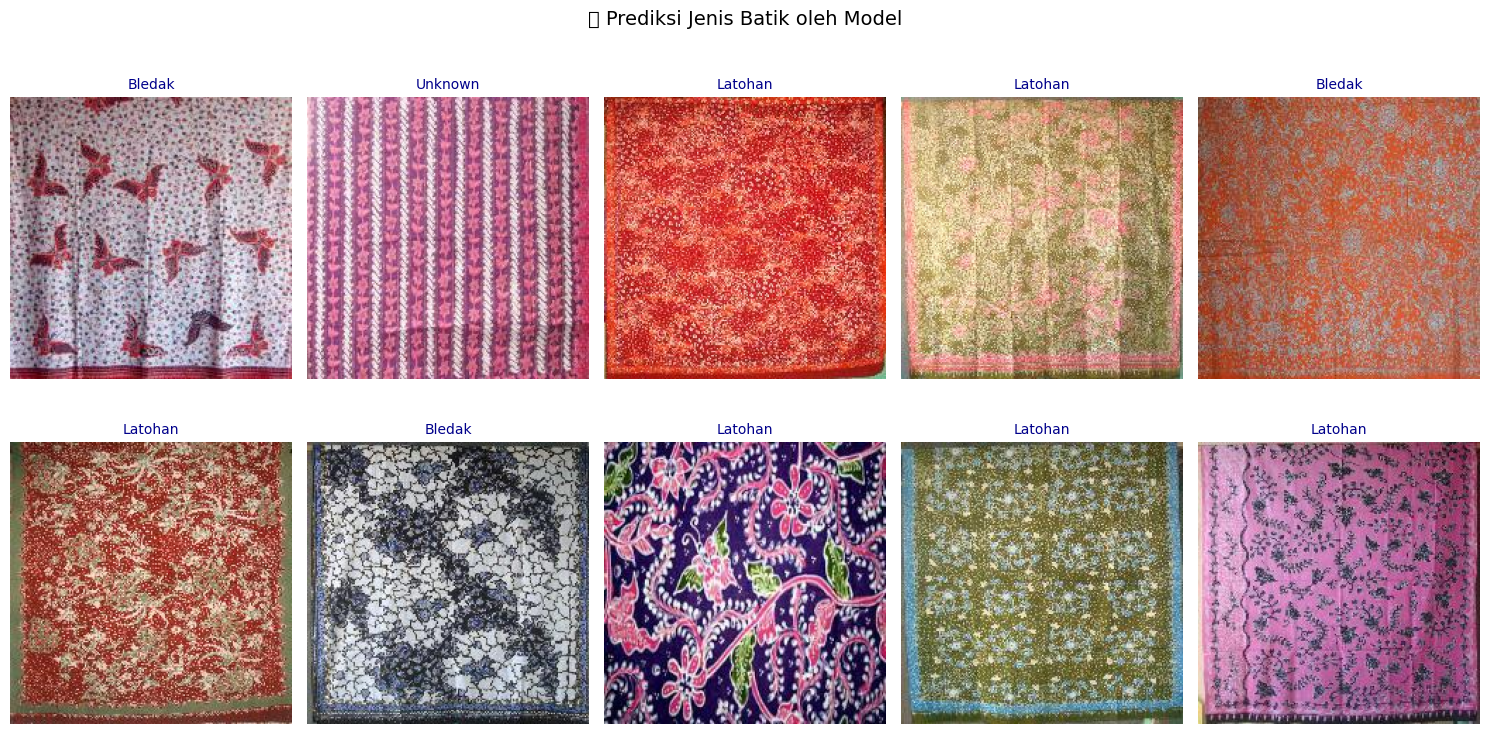

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# TAMPILKAN 10 HASIL PREDIKSI PERTAMA
print("\n🖼️ Contoh 10 hasil prediksi pertama:")
print(submission.head(10))

# VISUALISASI BEBERAPA GAMBAR
plt.figure(figsize=(15, 8))
for i in range(10):
    full_path = test_df.iloc[i]["full_path"]
    label = submission.iloc[i]["label"]
    img = mpimg.imread(full_path)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(label, fontsize=10, color="darkblue")
    plt.axis("off")

plt.suptitle("🔮 Prediksi Jenis Batik oleh Model", fontsize=14)
plt.tight_layout()
plt.show()


🚀 INITIALIZING TRAINING WITH EfficientNetV2B2...
📁 Base path: C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025
✅ Found 1101/1101 valid images
Found 881 validated image filenames belonging to 12 classes.
Found 220 validated image filenames belonging to 12 classes.
🎯 Classes found: 12
   Training samples: 881
   Validation samples: 220
   Class mapping: {'Aseman': 0, 'Bledak': 1, 'Gringsing': 2, 'Gunung Ringgit': 3, 'Kontemporer': 4, 'Krecak': 5, 'Latohan': 6, 'Naga': 7, 'Sekar Jagat': 8, 'Siang Malam': 9, 'Tumpal': 10, 'Unknown': 11}

Verifikasi Batch Data:
  Bentuk gambar (shape): (16, 260, 260, 3)
  Nilai piksel min: 0.00, max: 255.00
  Bentuk label (shape): (16, 12)

--- 🧠 STAGE 1: FEATURE EXTRACTION (WARM-UP) ---


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 260, 260,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_6     │ (None, 260, 260,  │          0 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ normalization_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 130, 130,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 130, 130,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 130, 130,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 130, 130,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 130, 130,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 130, 130,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 65, 65,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 65, 65,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 65, 65,    │          0 │ block2a_expand_b

 Total params: 8,791,914 (33.54 MB)

 Trainable params: 19,724 (77.05 KB)

 Non-trainable params: 8,772,190 (33.46 MB)

c:\Users\Elsie\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 48s 673ms/step - accuracy: 0.1759 - loss: 3.0806 - val_accuracy: 0.0773 - val_loss: 2.7328
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 920ms/step - accuracy: 0.2951 - loss: 2.5157 - val_accuracy: 0.1409 - val_loss: 2.6938
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 931ms/step - accuracy: 0.3950 - loss: 2.2218 - val_accuracy: 0.1364 - val_loss: 2.8767
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 882ms/step - accuracy: 0.4733 - loss: 1.9451 - val_accuracy: 0.1727 - val_loss: 2.9189
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 917ms/step - accuracy: 0.4847 - loss: 1.8477 - val_accuracy: 0.2909 - val_loss: 2.8906
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 53s 948ms/step - accuracy: 0.5187 - loss: 1.7321 - val_accuracy: 0.3318 - val_loss: 2.9662
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 941ms/step - accuracy: 0.5233 - loss: 1.7056 - val_accuracy: 0.3455 - val_loss: 2.9800
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 53s 952ms/step - accuracy: 0.5221 - loss: 1.6736 - val_accu

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 260, 260,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_6     │ (None, 260, 260,  │          0 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ normalization_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 130, 130,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 130, 130,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 130, 130,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 130, 130,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 130, 130,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 130, 130,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 65, 65,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 65, 65,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 65, 65,    │          0 │ block2a_expand_b

 Total params: 8,791,914 (33.54 MB)

 Trainable params: 3,620,048 (13.81 MB)

 Non-trainable params: 5,171,866 (19.73 MB)

Epoch 23/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - accuracy: 0.6008 - loss: 1.4525
Epoch 23: val_accuracy improved from None to 0.40000, saving model to efficientnet_batik_best.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.5936 - loss: 1.4396 - val_accuracy: 0.4000 - val_loss: 3.1704 - learning_rate: 1.0000e-05
Epoch 24/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.5900 - loss: 1.4645
Epoch 24: val_accuracy did not improve from 0.40000
56/56 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5925 - loss: 1.4645 - val_accuracy: 0.4000 - val_loss: 3.1830 - learning_rate: 1.0000e-05
Epoch 25/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6173 - loss: 1.4062
Epoch 25: val_accuracy improved from 0.40000 to 0.41364, saving model to efficientnet_batik_best.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.6141 - loss: 1.4263 - val_accuracy: 0.4136 - val_loss: 3.1528 - learning_rate: 1.0000e-05
Epoch 26/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - acc

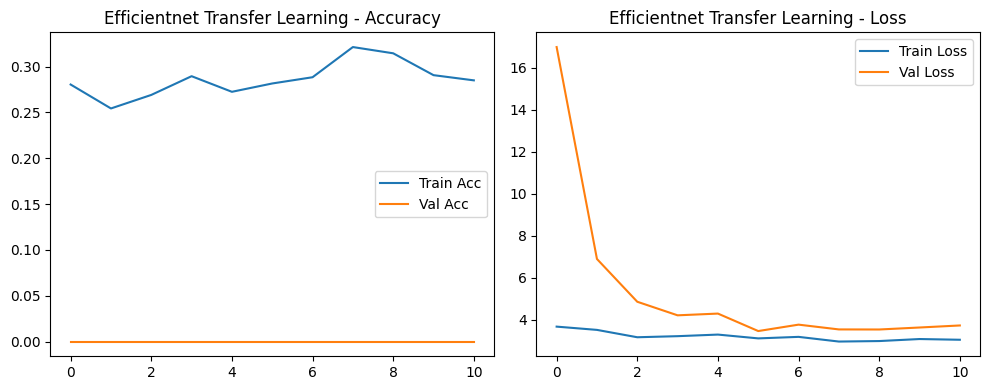

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ======================================================
# 🔧 PATH FIXER & DATA GENERATOR (DIPERBAIKI)
# ======================================================
def fix_data_generators(train_df, base_path):
    print(f"📁 Base path: {base_path}")
    label_col = [c for c in train_df.columns if "label" in c.lower() or "class" in c.lower()][0]
    image_col = [c for c in train_df.columns if "file" in c.lower() or "image" in c.lower() or "path" in c.lower()][0]
    train_df[label_col] = train_df[label_col].astype(str).str.strip().str.title()

    def find_path(fname):
        clean = os.path.basename(str(fname))
        for folder in ["train", "images", "data", "dataset", ""]:
            path = os.path.join(base_path, folder, clean)
            if os.path.exists(path):
                return path
        return None

    train_df["full_path"] = train_df[image_col].apply(find_path)
    valid_df = train_df[train_df["full_path"].notna()].copy() # Gunakan .copy() untuk menghindari SettingWithCopyWarning
    print(f"✅ Found {len(valid_df)}/{len(train_df)} valid images")

    # ### FIX UTAMA: HAPUS `rescale=1./255` ###
    # EfficientNetV2 sudah melakukan rescaling di dalam modelnya.
    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=25,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.2,
        shear_range=0.15,
        brightness_range=[0.8, 1.2],
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Generator validasi tidak perlu augmentasi, dan juga TANPA rescale.
    val_datagen = ImageDataGenerator(validation_split=0.2)

    train_gen = train_datagen.flow_from_dataframe(
        valid_df,
        x_col="full_path",
        y_col=label_col,
        target_size=(260, 260),  # Gunakan resolusi yang sedikit lebih tinggi untuk EfficientNet
        class_mode="categorical",
        batch_size=16, # Turunkan batch size untuk gambar yang lebih besar
        subset="training",
        shuffle=True,
        seed=42
    )

    val_gen = val_datagen.flow_from_dataframe(
        valid_df,
        x_col="full_path",
        y_col=label_col,
        target_size=(260, 260),
        class_mode="categorical",
        batch_size=16,
        subset="validation",
        shuffle=False,
        seed=42
    )
    
    # --- DIAGNOSTIK PENTING ---
    print(f"🎯 Classes found: {len(train_gen.class_indices)}")
    print(f"   Training samples: {train_gen.samples}")
    print(f"   Validation samples: {val_gen.samples}")
    print(f"   Class mapping: {train_gen.class_indices}")

    # Verifikasi satu batch data
    X_batch, y_batch = next(iter(train_gen))
    print(f"\nVerifikasi Batch Data:")
    print(f"  Bentuk gambar (shape): {X_batch.shape}")
    print(f"  Nilai piksel min: {X_batch.min():.2f}, max: {X_batch.max():.2f}") # HARUS dalam range [0, 255]
    print(f"  Bentuk label (shape): {y_batch.shape}")
    
    return train_gen, val_gen

# ======================================================
# 🚀 TRANSFER LEARNING MODEL (DIPERBAIKI)
# ======================================================
def create_transfer_model(num_classes, input_shape=(260, 260, 3)):
    # Muat base model. Layer rescaling sudah termasuk di dalamnya.
    base_model = EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False # Bekukan seluruh base model pada awalnya

    # Sederhanakan head model untuk stabilitas awal
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.BatchNormalization()(x) # Tambahkan BN sebelum Dropout
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=output)
    return model, base_model

# ======================================================
# 🧠 FUNGSI TRAINING (DIPERBAIKI DENGAN STRATEGI BARU)
# ======================================================
def train_model(train_df, base_path):
    print("🚀 INITIALIZING TRAINING WITH EfficientNetV2B2...")
    train_gen, val_gen = fix_data_generators(train_df, base_path)
    num_classes = len(train_gen.class_indices)
    
    model, base_model = create_transfer_model(num_classes=num_classes)

    print("\n--- 🧠 STAGE 1: FEATURE EXTRACTION (WARM-UP) ---")
    model.compile(
        optimizer=AdamW(learning_rate=5e-4), # Gunakan LR yang lebih aman
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    model.summary()

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, mode='max', verbose=1)
    
    history_head = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=25,
        callbacks=[early_stopping],
        verbose=1
    )
    
    print("\n✅ STAGE 1 COMPLETE!")
    val_loss_s1, val_acc_s1 = model.evaluate(val_gen, verbose=0)
    print(f"✅ Accuracy after Stage 1: {val_acc_s1:.4f}")

    if val_acc_s1 < 0.1:
        print("❌ Accuracy Stage 1 sangat rendah. Training dihentikan. Cek kembali data Anda.")
        return model, history_head, train_gen, val_gen

    print("\n--- FINE-TUNING ---")
    
    base_model.trainable = True
    
    for layer in base_model.layers:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = False

    fine_tune_at = -80
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    model.compile(
        optimizer=AdamW(learning_rate=1e-5, weight_decay=1e-6), # LR yang sangat kecil untuk fine-tuning
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    model.summary()

    callbacks_ft = [
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7, verbose=1),
        ModelCheckpoint('efficientnet_batik_best.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    ]
    
    history_fine_tune = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        callbacks=callbacks_ft,
        initial_epoch=history_head.epoch[-1] + 1 if history_head.epoch else 0, # Handle jika stage 1 berhenti di epoch 0
        verbose=1
    )

    plot_training_history(history, "Efficientnet Transfer Learning")

    return model, history, train_gen, val_gen


def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f"{title} - Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{title} - Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
# ======================================================
if 'train_df' in globals() and train_df is not None:
    base_path = r"C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025"
    # Hapus class_weights, kita coba tanpa itu dulu
    train_model(train_df, base_path) 
else:
    print("❌ train_df not found! Please load your train CSV first.")

In [13]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tqdm import tqdm

# ======================================================
# SETUP PATH
# ======================================================
base_path = r"C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025"
model_path = r"C:\GitHub\web\DL_Batik-Image-Classification\efficientnet_batik_best.keras"

# ======================================================
# LOAD CSV DAN MODEL
# ======================================================
try:
    test_df = pd.read_csv("C:/Users/Elsie/OneDrive/Desktop/DEEPLEARNING/untar-deep-learning-course-1-2-gj-2526/test.csv")
    model = load_model(model_path)
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model or CSV: {e}")
    exit()

# ======================================================
# BUAT FULL PATH GAMBAR TEST
# ======================================================
def find_test_path(fname):
    clean = os.path.basename(str(fname))
    # Pastikan untuk mencari di dalam folder test
    for folder in ["test", "images", "data", "dataset", ""]:
        path = os.path.join(base_path, folder, clean)
        if os.path.exists(path):
            return path
    return None

test_df["full_path"] = test_df["filename"].apply(find_test_path)
test_df = test_df[test_df["full_path"].notna()]
print(f"✅ Found {len(test_df)} valid test images")

if len(test_df) == 0:
    raise ValueError("❌ Tidak ada gambar test yang ditemukan. Cek kembali base_path dan nama folder test.")

# ======================================================
# DATA GENERATOR UNTUK PREDIKSI (DIPERBAIKI)
# ======================================================
# FIX #1: Hapus `rescale=1./255`. Model sudah punya layer rescaling internal.
test_datagen = ImageDataGenerator() # <-- TANPA RESCALE

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="full_path",
    y_col=None, # Tidak ada label y untuk data test
    # FIX #2: Gunakan target_size yang sama dengan saat training.
    target_size=(260, 260), # <-- GANTI KE 260x260
    class_mode=None, # Penting untuk data test
    batch_size=32,   # Batch size bisa disesuaikan, 32 sudah bagus
    shuffle=False    # JANGAN di-shuffle agar urutan prediksi sesuai
)

# ======================================================
# PREDIKSI
# ======================================================
print("🚀 Predicting test data...")
pred_probs = model.predict(test_gen, verbose=1)
pred_labels = np.argmax(pred_probs, axis=1)

# ======================================================
# MAPPING LABEL DAN SIMPAN CSV
# ======================================================
# PENTING: Urutan label ini HARUS SAMA PERSIS dengan urutan
# yang dipelajari model saat training (biasanya urutan abjad).
label_map = sorted([
    'Aseman', 'Bledak', 'Gringsing', 'Gunung Ringgit', 'Kontemporer', 'Krecak',
    'Latohan', 'Naga', 'Sekar Jagat', 'Siang Malam', 'Tumpal', 'Unknown'
])

# Cek kesesuaian jumlah kelas
if len(label_map) != model.output_shape[-1]:
    print(f"⚠️ Warning: Jumlah kelas model ({model.output_shape[-1]}) tidak sama dengan label_map ({len(label_map)})!")
else:
    print("✅ Label map and model output shape match.")

# Ambil nama kelas berdasarkan indeks prediksi
pred_class_names = [label_map[i] for i in pred_labels]

# Buat DataFrame untuk submission
submission = pd.DataFrame({
    "id": test_df["id"],
    "label": pred_class_names
})

# Simpan ke CSV
submission.to_csv("submission.csv", index=False)
print("\n✅ Predictions saved to submission.csv")
print("Submission file head:")
print(submission.head())

✅ Model loaded successfully!
✅ Found 741 valid test images
Found 741 validated image filenames.
🚀 Predicting test data...


c:\Users\Elsie\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step 
✅ Label map and model output shape match.

✅ Predictions saved to submission.csv
Submission file head:
   id    label
0   0   Bledak
1   1  Unknown
2   2  Latohan
3   3  Latohan
4   4  Unknown


🚀 INITIALIZING TRAINING WITH EfficientNetV2B2 (Light Augmentation)...
📁 Base path: C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025
✅ Found 1101/1101 valid images
Found 881 validated image filenames belonging to 12 classes.
Found 220 validated image filenames belonging to 12 classes.
🎯 Classes found: 12
   Training samples: 881
   Validation samples: 220
   Class mapping: {'Aseman': 0, 'Bledak': 1, 'Gringsing': 2, 'Gunung Ringgit': 3, 'Kontemporer': 4, 'Krecak': 5, 'Latohan': 6, 'Naga': 7, 'Sekar Jagat': 8, 'Siang Malam': 9, 'Tumpal': 10, 'Unknown': 11}

Verifikasi Batch Data:
  Bentuk gambar (shape): (16, 260, 260, 3)
  Nilai piksel min: 0.00, max: 255.00
  Bentuk label (shape): (16, 12)

--- 🧠 STAGE 1: FEATURE EXTRACTION (WARM-UP) ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 260, 260,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 260, 260,  │          0 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 130, 130,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 130, 130,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 130, 130,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 130, 130,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 130, 130,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 130, 130,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 65, 65,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 65, 65,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 65, 65,    │          0 │ block2a_expand_b

 Total params: 8,791,914 (33.54 MB)

 Trainable params: 19,724 (77.05 KB)

 Non-trainable params: 8,772,190 (33.46 MB)

c:\Users\Elsie\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 904ms/step - accuracy: 0.1510 - loss: 3.1660 - val_accuracy: 0.1636 - val_loss: 2.6201
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 845ms/step - accuracy: 0.3156 - loss: 2.4182 - val_accuracy: 0.2182 - val_loss: 2.6101
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 719ms/step - accuracy: 0.3893 - loss: 2.1273 - val_accuracy: 0.2591 - val_loss: 2.6842
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 748ms/step - accuracy: 0.4677 - loss: 1.8698 - val_accuracy: 0.3273 - val_loss: 2.6331
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 751ms/step - accuracy: 0.5131 - loss: 1.7527 - val_accuracy: 0.3591 - val_loss: 2.7080
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 702ms/step - accuracy: 0.5255 - loss: 1.6992 - val_accuracy: 0.3636 - val_loss: 2.8268
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 786ms/step - accuracy: 0.5369 - loss: 1.5975 - val_accuracy: 0.3682 - val_loss: 2.8622
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 771ms/step - accuracy: 0.5516 - loss: 1.6080 - val_accu

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 260, 260,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 260, 260,  │          0 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 130, 130,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 130, 130,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 130, 130,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 130, 130,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 130, 130,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 130, 130,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 65, 65,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 65, 65,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 65, 65,    │          0 │ block2a_expand_b

 Total params: 8,791,914 (33.54 MB)

 Trainable params: 3,620,048 (13.81 MB)

 Non-trainable params: 5,171,866 (19.73 MB)

Epoch 24/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.6192 - loss: 1.4045
Epoch 24: val_accuracy improved from None to 0.39545, saving model to efficientnet_batik_best.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 69s 943ms/step - accuracy: 0.6243 - loss: 1.3948 - val_accuracy: 0.3955 - val_loss: 3.0998 - learning_rate: 1.0000e-05
Epoch 25/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.6088 - loss: 1.3889
Epoch 25: val_accuracy improved from 0.39545 to 0.40000, saving model to efficientnet_batik_best.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 874ms/step - accuracy: 0.6050 - loss: 1.3916 - val_accuracy: 0.4000 - val_loss: 3.1304 - learning_rate: 1.0000e-05
Epoch 26/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.6315 - loss: 1.3154
Epoch 26: val_accuracy did not improve from 0.40000
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 847ms/step - accuracy: 0.6186 - loss: 1.3575 - val_accuracy: 0.4000 - val_loss: 3.1407 - learning_rate: 1.0000e-05
Epoch 27/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 719m

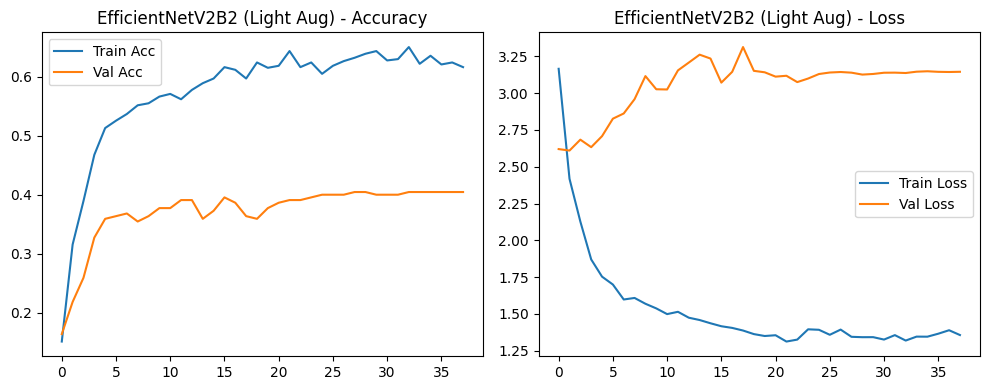

In [12]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- IMPORT MODEL STABIL ---
from tensorflow.keras.applications import EfficientNetV2B2
# -------------------------

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np

# ======================================================
# 🔧 PATH FIXER & DATA GENERATOR
# (PERBAIKAN AUGMENTASI ADA DI SINI!)
# ======================================================
def fix_data_generators(train_df, base_path):
    print(f"📁 Base path: {base_path}")
    label_col = [c for c in train_df.columns if "label" in c.lower() or "class" in c.lower()][0]
    image_col = [c for c in train_df.columns if "file" in c.lower() or "image" in c.lower() or "path" in c.lower()][0]
    train_df[label_col] = train_df[label_col].astype(str).str.strip().str.title()

    def find_path(fname):
        clean = os.path.basename(str(fname))
        for folder in ["train", "images", "data", "dataset", ""]:
            path = os.path.join(base_path, folder, clean)
            if os.path.exists(path):
                return path
        return None

    train_df["full_path"] = train_df[image_col].apply(find_path)
    valid_df = train_df[train_df["full_path"].notna()].copy()
    print(f"✅ Found {len(valid_df)}/{len(train_df)} valid images")

    # ### PERBAIKAN AUGMENTASI (SESUAI PERMINTAAN) ###
    # Hanya 4 augmentasi ringan.
    # PENTING: TIDAK ADA rescale=1./255!
    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        horizontal_flip=True,   # 1
        rotation_range=10,      # 2 (Diturunkan dari 25)
        zoom_range=0.1,         # 3 (Diturunkan dari 0.2)
        width_shift_range=0.1,  # 4 (Diturunkan dari 0.15)
        # Shear, brightness, height_shift DIHAPUS
        fill_mode='nearest'
    )

    # Generator validasi juga TANPA rescale.
    val_datagen = ImageDataGenerator(validation_split=0.2)
    
    # Ukuran B2 adalah 260
    TARGET_SIZE = (260, 260)

    train_gen = train_datagen.flow_from_dataframe(
        valid_df,
        x_col="full_path",
        y_col=label_col,
        target_size=TARGET_SIZE,
        class_mode="categorical",
        batch_size=16, 
        subset="training",
        shuffle=True,
        seed=42
    )

    val_gen = val_datagen.flow_from_dataframe(
        valid_df,
        x_col="full_path",
        y_col=label_col,
        target_size=TARGET_SIZE,
        class_mode="categorical",
        batch_size=16,
        subset="validation",
        shuffle=False,
        seed=42
    )
    
    print(f"🎯 Classes found: {len(train_gen.class_indices)}")
    print(f"   Training samples: {train_gen.samples}")
    print(f"   Validation samples: {val_gen.samples}")
    print(f"   Class mapping: {train_gen.class_indices}")

    # Verifikasi satu batch data
    X_batch, y_batch = next(iter(train_gen))
    print(f"\nVerifikasi Batch Data:")
    print(f"  Bentuk gambar (shape): {X_batch.shape}")
    # KARENA KITA TIDAK RESCALE, INI HARUS [0, 255]
    print(f"  Nilai piksel min: {X_batch.min():.2f}, max: {X_batch.max():.2f}") 
    print(f"  Bentuk label (shape): {y_batch.shape}")
    
    return train_gen, val_gen

# ======================================================
# 🚀 TRANSFER LEARNING MODEL (EfficientNetV2B2)
# (Tidak ada perubahan)
# ======================================================
def create_transfer_model(num_classes, input_shape=(260, 260, 3)):
    base_model = EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False 

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.BatchNormalization()(x) 
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=output)
    return model, base_model

# ======================================================
# 🧠 FUNGSI TRAINING (STRATEGI 2-TAHAP)
# (Tidak ada perubahan)
# ======================================================
def train_model(train_df, base_path):
    print("🚀 INITIALIZING TRAINING WITH EfficientNetV2B2 (Light Augmentation)...")
    train_gen, val_gen = fix_data_generators(train_df, base_path)
    num_classes = len(train_gen.class_indices)
    
    model, base_model = create_transfer_model(num_classes=num_classes)

    # --- STAGE 1: FEATURE EXTRACTION ---
    print("\n--- 🧠 STAGE 1: FEATURE EXTRACTION (WARM-UP) ---")
    model.compile(
        optimizer=AdamW(learning_rate=5e-4),
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    model.summary()

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, mode='max', verbose=1)
    
    history_head = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=25,
        callbacks=[early_stopping],
        verbose=1
    )
    
    print("\n✅ STAGE 1 COMPLETE!")
    val_loss_s1, val_acc_s1 = model.evaluate(val_gen, verbose=0)
    print(f"✅ Accuracy after Stage 1: {val_acc_s1:.4f}")

    if val_acc_s1 < 0.1 and num_classes > 2:
        print(f"❌ Akurasi Stage 1 ({val_acc_s1:.4f}) sangat rendah. Cek data Anda.")
        return model, history_head, train_gen, val_gen

    # --- STAGE 2: FINE-TUNING ---
    print("\n--- 🔥 STAGE 2: FINE-TUNING ---")
    
    base_model.trainable = True
    
    for layer in base_model.layers:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = False

    fine_tune_at = -80
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(
        optimizer=AdamW(learning_rate=1e-5, weight_decay=1e-6), 
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    model.summary()

    callbacks_ft = [
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7, verbose=1),
        ModelCheckpoint('efficientnet_batik_best.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    ]
    
    initial_epoch_ft = len(history_head.history['loss'])

    history_fine_tune = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        callbacks=callbacks_ft,
        initial_epoch=initial_epoch_ft,
        verbose=1
    )

    print("\n✅ TRAINING COMPLETE!")
    print("🔄 Loading best weights from efficientnet_batik_best.keras...")
    model.load_weights('efficientnet_batik_best.keras')
    
    val_loss_final, val_acc_final = model.evaluate(val_gen, verbose=0)
    print(f"🏆 Final Validation Accuracy (Best): {val_acc_final:.4f}")
    
    history_combined = combine_histories(history_head, history_fine_tune)
    plot_training_history(history_combined, "EfficientNetV2B2 (Light Aug)")

    return model, history_combined, train_gen, val_gen

# ======================================================
# 📊 VISUALIZATION (DENGAN HELPER)
# (Tidak ada perubahan)
# ======================================================

def combine_histories(h1, h2):
    """Menggabungkan dua history training (untuk plot)."""
    history = {}
    for key in h1.history.keys():
        if key in h2.history:
             history[key] = h1.history[key] + h2.history[key]
    return history

def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(10,4))
    
    if 'accuracy' in history:
        plt.subplot(1,2,1)
        plt.plot(history['accuracy'], label='Train Acc')
        plt.plot(history['val_accuracy'], label='Val Acc')
        plt.title(f"{title} - Accuracy")
        plt.legend()
    
    if 'loss' in history:
        plt.subplot(1,2,2)
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.title(f"{title} - Loss")
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
# ======================================================
# 🏁 MAIN EXECUTION
# ======================================================
if 'train_df' in globals() and train_df is not None:
    base_path = r"C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025"
    train_model(train_df, base_path) 
else:
    print("❌ train_df not found! Please load your train CSV first.")

🚀 INITIALIZING TRAINING WITH EfficientNetV2B0 (Smaller Model)...
📁 Base path: C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025
✅ Found 1101/1101 valid images
Found 881 validated image filenames belonging to 12 classes.
Found 220 validated image filenames belonging to 12 classes.
🎯 Classes found: 12
   Training samples: 881
   Validation samples: 220

Verifikasi Batch Data:
  Bentuk gambar (shape): (16, 224, 224, 3)
  Nilai piksel min: 0.00, max: 255.00
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 22s 1us/step

--- 🧠 STAGE 1: FEATURE EXTRACTION (WARM-UP) ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          0 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 6,588,508 (25.13 MB)

 Trainable params: 665,612 (2.54 MB)

 Non-trainable params: 5,922,896 (22.59 MB)

c:\Users\Elsie\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 521ms/step - accuracy: 0.2974 - loss: 3.0851 - val_accuracy: 0.3727 - val_loss: 2.2133
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 533ms/step - accuracy: 0.4427 - loss: 2.5222 - val_accuracy: 0.3818 - val_loss: 2.2905
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 422ms/step - accuracy: 0.5233 - loss: 2.1141 - val_accuracy: 0.3545 - val_loss: 2.4421
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 411ms/step - accuracy: 0.5471 - loss: 1.9265 - val_accuracy: 0.3818 - val_loss: 2.3628
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 416ms/step - accuracy: 0.5471 - loss: 1.8170 - val_accuracy: 0.3818 - val_loss: 2.7698
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 410ms/step - accuracy: 0.5970 - loss: 1.7046 - val_accuracy: 0.3955 - val_loss: 2.7183
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 406ms/step - accuracy: 0.6141 - loss: 1.6040 - val_accuracy: 0.3909 - val_loss: 2.6433
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 413ms/step - accuracy: 0.5732 - loss: 1.6316 - val_accu

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          0 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 6,588,508 (25.13 MB)

 Trainable params: 2,948,300 (11.25 MB)

 Non-trainable params: 3,640,208 (13.89 MB)

Epoch 20/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - accuracy: 0.6215 - loss: 1.4692
Epoch 20: val_accuracy improved from None to 0.40000, saving model to efficientnetB0_batik_best.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.6538 - loss: 1.4147 - val_accuracy: 0.4000 - val_loss: 3.0813 - learning_rate: 5.0000e-05
Epoch 21/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.6616 - loss: 1.4058
Epoch 21: val_accuracy improved from 0.40000 to 0.40455, saving model to efficientnetB0_batik_best.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6731 - loss: 1.3827 - val_accuracy: 0.4045 - val_loss: 3.1366 - learning_rate: 5.0000e-05
Epoch 22/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.6706 - loss: 1.4034
Epoch 22: val_accuracy did not improve from 0.40455
56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 998ms/step - accuracy: 0.6731 - loss: 1.3713 - val_accuracy: 0.4045 - val_loss: 3.1009 - learning_rate: 5.0000e-05
Epoch 23/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms

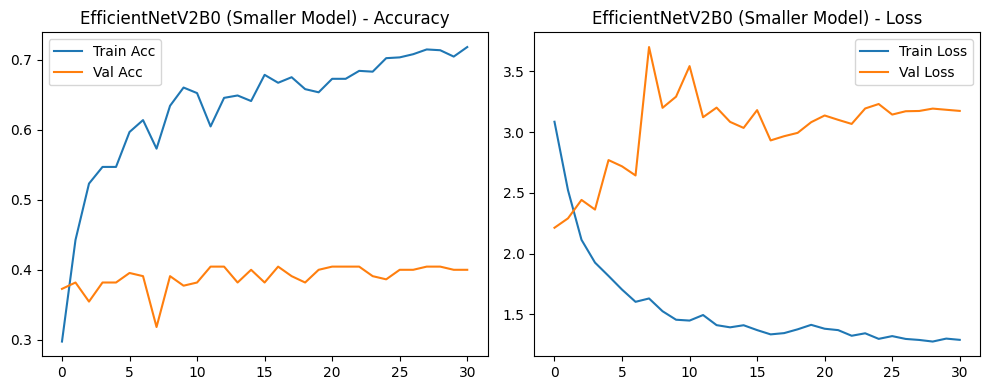

In [ ]:
#-----------------------try4
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- IMPORT MODEL BARU (LEBIH KECIL) ---
from tensorflow.keras.applications import EfficientNetV2B0 # <-- GANTI KE B0
# -------------------------

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np

# ======================================================
# 🔧 PATH FIXER & DATA GENERATOR
# (Kita pakai AUGMENTASI KUAT untuk lawan overfit)
# ======================================================
def fix_data_generators(train_df, base_path):
    print(f"📁 Base path: {base_path}")
    label_col = [c for c in train_df.columns if "label" in c.lower() or "class" in c.lower()][0]
    image_col = [c for c in train_df.columns if "file" in c.lower() or "image" in c.lower() or "path" in c.lower()][0]
    train_df[label_col] = train_df[label_col].astype(str).str.strip().str.title()

    def find_path(fname):
        clean = os.path.basename(str(fname))
        for folder in ["train", "images", "data", "dataset", ""]:
            path = os.path.join(base_path, folder, clean)
            if os.path.exists(path):
                return path
        return None

    train_df["full_path"] = train_df[image_col].apply(find_path)
    valid_df = train_df[train_df["full_path"].notna()].copy()
    print(f"✅ Found {len(valid_df)}/{len(train_df)} valid images")

    # --- AUGMENTASI KUAT untuk lawan overfit ---
    train_datagen = ImageDataGenerator(
        # TIDAK ADA rescale=1./255!
        validation_split=0.2,
        rotation_range=25,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.2,
        shear_range=0.15,
        brightness_range=[0.8, 1.2],
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Generator validasi juga TANPA rescale.
    val_datagen = ImageDataGenerator(validation_split=0.2)
    
    # Ukuran B0 adalah 224
    TARGET_SIZE = (224, 224) # <-- GANTI UKURAN

    train_gen = train_datagen.flow_from_dataframe(
        valid_df,
        x_col="full_path",
        y_col=label_col,
        target_size=TARGET_SIZE,
        class_mode="categorical",
        batch_size=16, # Batch size kecil bagus
        subset="training",
        shuffle=True,
        seed=42
    )

    val_gen = val_datagen.flow_from_dataframe(
        valid_df,
        x_col="full_path",
        y_col=label_col,
        target_size=TARGET_SIZE,
        class_mode="categorical",
        batch_size=16,
        subset="validation",
        shuffle=False,
        seed=42
    )
    
    print(f"🎯 Classes found: {len(train_gen.class_indices)}")
    print(f"   Training samples: {train_gen.samples}")
    print(f"   Validation samples: {val_gen.samples}")

    X_batch, y_batch = next(iter(train_gen))
    print(f"\nVerifikasi Batch Data:")
    print(f"  Bentuk gambar (shape): {X_batch.shape}")
    print(f"  Nilai piksel min: {X_batch.min():.2f}, max: {X_batch.max():.2f}") # HARUS [0, 255]
    
    return train_gen, val_gen

# ======================================================
# 🚀 TRANSFER LEARNING MODEL (EfficientNetV2B0)
# ======================================================
def create_transfer_model(num_classes, input_shape=(224, 224, 3)):
    # --- GANTI MODEL KE B0 ---
    base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False 

    # --- Kita pakai HEAD YANG KUAT & REGULARIZED ---
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x) # Head Kuat
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x) # Dropout 50%
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=output)
    return model, base_model

# ======================================================
# 🧠 FUNGSI TRAINING (Strategi 2-Tahap)
# ======================================================
def train_model(train_df, base_path):
    print("🚀 INITIALIZING TRAINING WITH EfficientNetV2B0 (Smaller Model)...")
    train_gen, val_gen = fix_data_generators(train_df, base_path)
    num_classes = len(train_gen.class_indices)
    
    model, base_model = create_transfer_model(num_classes=num_classes)

    # --- STAGE 1: FEATURE EXTRACTION (WARM-UP HEAD) ---
    print("\n--- 🧠 STAGE 1: FEATURE EXTRACTION (WARM-UP) ---")
    model.compile(
        optimizer=AdamW(learning_rate=1e-3), # LR tinggi untuk head baru
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    model.summary()

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, mode='max', verbose=1)
    
    history_head = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=30, # Beri 30 epoch untuk warm-up head baru
        callbacks=[early_stopping],
        verbose=1
    )
    
    print("\n✅ STAGE 1 COMPLETE!")
    val_loss_s1, val_acc_s1 = model.evaluate(val_gen, verbose=0)
    print(f"✅ Accuracy after Stage 1: {val_acc_s1:.4f}")

    if val_acc_s1 < 0.3: # Jika warm-up masih di bawah 30%, ada yg salah
        print(f"❌ Akurasi Stage 1 ({val_acc_s1:.4f}) sangat rendah. Cek data Anda.")
        return model, history_head, train_gen, val_gen

    # --- STAGE 2: FINE-TUNING ---
    print("\n--- 🔥 STAGE 2: FINE-TUNING ---")
    
    base_model.trainable = True
    
    for layer in base_model.layers:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = False

    fine_tune_at = -60 # B0 lebih kecil, -60 sudah cukup
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(
        optimizer=AdamW(learning_rate=5e-5, weight_decay=1e-6), # LR kecil untuk fine-tune
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    model.summary()

    callbacks_ft = [
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1),
        ModelCheckpoint('efficientnetB0_batik_best.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1) # Nama file baru
    ]
    
    initial_epoch_ft = len(history_head.history['loss'])

    history_fine_tune = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=60, # Total epoch lebih banyak
        callbacks=callbacks_ft,
        initial_epoch=initial_epoch_ft,
        verbose=1
    )

    print("\n✅ TRAINING COMPLETE!")
    print("🔄 Loading best weights from efficientnetB0_batik_best.keras...")
    model.load_weights('efficientnetB0_batik_best.keras')
    
    val_loss_final, val_acc_final = model.evaluate(val_gen, verbose=0)
    print(f"🏆 Final Validation Accuracy (Best): {val_acc_final:.4f}")
    
    history_combined = combine_histories(history_head, history_fine_tune)
    plot_training_history(history_combined, "EfficientNetV2B0 (Smaller Model)")

    return model, history_combined, train_gen, val_gen

# ======================================================
# 📊 VISUALIZATION (DENGAN HELPER)
# (Tidak ada perubahan)
# ======================================================

def combine_histories(h1, h2):
    """Menggabungkan dua history training (untuk plot)."""
    history = {}
    for key in h1.history.keys():
        if key in h2.history:
             history[key] = h1.history[key] + h2.history[key]
    return history

def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(10,4))
    
    if 'accuracy' in history:
        plt.subplot(1,2,1)
        plt.plot(history['accuracy'], label='Train Acc')
        plt.plot(history['val_accuracy'], label='Val Acc')
        plt.title(f"{title} - Accuracy")
        plt.legend()
    
    if 'loss' in history:
        plt.subplot(1,2,2)
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.title(f"{title} - Loss")
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
# ======================================================
# 🏁 MAIN EXECUTION
# (Tidak ada perubahan)
# ======================================================
if 'train_df' in globals() and train_df is not None:
    base_path = r"C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025"
    train_model(train_df, base_path) 
else:
    print("❌ train_df not found! Please load your train CSV first.")

🚀 INITIALIZING TRAINING (Custom CNN 'From Scratch')...
📁 Base path: C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025
✅ Found 1101/1101 valid images
Found 881 validated image filenames belonging to 12 classes.
Found 220 validated image filenames belonging to 12 classes.
🎯 Classes found: 12
⚖️ Class Weights Dihitung:
{np.int64(1): np.float64(1.9665178571428572), np.int64(3): np.float64(11.0125), np.int64(5): np.float64(3.1464285714285714), np.int64(6): np.float64(0.3463050314465409), np.int64(8): np.float64(5.244047619047619), np.int64(9): np.float64(36.708333333333336), np.int64(10): np.float64(1.4118589743589745), np.int64(11): np.float64(0.3059027777777778)}

Verifikasi Batch Data:
  Bentuk gambar (shape): (32, 150, 150, 3)
  Nilai piksel min: 0.00, max: 1.00

--- 🧠 Compiling Model 'From Scratch' ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 290,348 (1.11 MB)

 Trainable params: 289,452 (1.10 MB)

 Non-trainable params: 896 (3.50 KB)

c:\Users\Elsie\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1252 - loss: 3.0285
Epoch 1: val_accuracy improved from None to 0.37727, saving model to custom_cnn_batik_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.1283 - loss: 3.1196 - val_accuracy: 0.3773 - val_loss: 2.3642 - learning_rate: 0.0010
Epoch 2/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1127 - loss: 2.5800
Epoch 2: val_accuracy improved from 0.37727 to 0.45000, saving model to custom_cnn_batik_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.1146 - loss: 2.7151 - val_accuracy: 0.4500 - val_loss: 2.5411 - learning_rate: 0.0010
Epoch 3/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1769 - loss: 2.3760
Epoch 3: val_accuracy improved from 0.45000 to 0.45455, saving model to custom_cnn_batik_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.1680 - loss: 2.3203 - val_accuracy: 0.4545 - val_loss: 2.5571 - learning_rate: 0.0010
Epoch 4/80
28/28 ━━━━━━━━━━━━━━━━━━━━

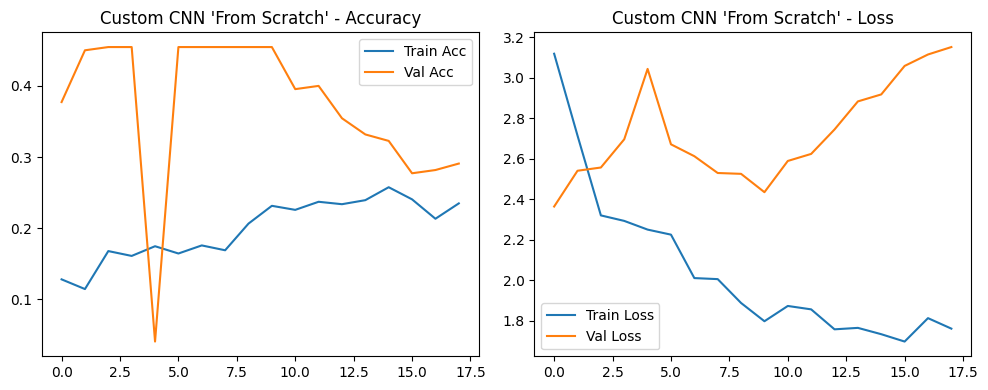

In [14]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# --- TIDAK ADA IMPORT EfficientNet, VGG, dll. KITA BUAT SENDIRI ---
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
from sklearn.utils import class_weight # <-- Tetap kita pakai

# ======================================================
# 🔧 PATH FIXER & DATA GENERATOR
# (PERUBAHAN #1: KEMBALIKAN RESCALE=1./255!)
# ======================================================
def fix_data_generators(train_df, base_path):
    print(f"📁 Base path: {base_path}")
    label_col = [c for c in train_df.columns if "label" in c.lower() or "class" in c.lower()][0]
    image_col = [c for c in train_df.columns if "file" in c.lower() or "image" in c.lower() or "path" in c.lower()][0]
    train_df[label_col] = train_df[label_col].astype(str).str.strip().str.title()

    def find_path(fname):
        clean = os.path.basename(str(fname))
        for folder in ["train", "images", "data", "dataset", ""]:
            path = os.path.join(base_path, folder, clean)
            if os.path.exists(path):
                return path
        return None

    train_df["full_path"] = train_df[image_col].apply(find_path)
    valid_df = train_df[train_df["full_path"].notna()].copy()
    print(f"✅ Found {len(valid_df)}/{len(train_df)} valid images")

    # --- KEMBALIKAN RESCALE & AUGMENTASI KUAT ---
    train_datagen = ImageDataGenerator(
        rescale=1./255, # <-- KRUSIAL: Model kustom BUTUH ini
        validation_split=0.2,
        rotation_range=25,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Validation generator juga BUTUH rescale
    val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    # Ukuran lebih kecil untuk model "bodoh"
    TARGET_SIZE = (150, 150) # <-- GANTI UKURAN

    train_gen = train_datagen.flow_from_dataframe(
        valid_df,
        x_col="full_path",
        y_col=label_col,
        target_size=TARGET_SIZE,
        class_mode="categorical",
        batch_size=32, # Batch size bisa lebih besar
        subset="training",
        shuffle=True,
        seed=42
    )

    val_gen = val_datagen.flow_from_dataframe(
        valid_df,
        x_col="full_path",
        y_col=label_col,
        target_size=TARGET_SIZE,
        class_mode="categorical",
        batch_size=32,
        subset="validation",
        shuffle=False,
        seed=42
    )
    
    print(f"🎯 Classes found: {len(train_gen.class_indices)}")
    
    # --- PERHITUNGAN CLASS WEIGHT ---
    y_train = train_gen.classes
    class_labels = np.unique(y_train)
    weights = class_weight.compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
    class_weights_dict = dict(zip(class_labels, weights))
    print(f"⚖️ Class Weights Dihitung:")
    print(class_weights_dict)
    # ---------------------------------
    
    X_batch, y_batch = next(iter(train_gen))
    print(f"\nVerifikasi Batch Data:")
    print(f"  Bentuk gambar (shape): {X_batch.shape}")
    print(f"  Nilai piksel min: {X_batch.min():.2f}, max: {X_batch.max():.2f}") # <-- HARUS [0, 1] SEKARANG!
    
    return train_gen, val_gen, class_weights_dict

# ======================================================
# 🚀 MODEL KUSTOM "BODOH"
# (PERUBAHAN #2: BUAT MODEL DARI NOL)
# ======================================================
def create_custom_model(num_classes, input_shape=(150, 150, 3)):
    
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape)) # Input layer
    
    # Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Head
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5)) # Dropout 50% untuk lawan overfit
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# ======================================================
# 🧠 FUNGSI TRAINING (STRATEGI 1-TAHAP)
# ======================================================
def train_model(train_df, base_path):
    print("🚀 INITIALIZING TRAINING (Custom CNN 'From Scratch')...")
    
    # Dapatkan class weights dari generator
    train_gen, val_gen, class_weights = fix_data_generators(train_df, base_path)
    num_classes = len(train_gen.class_indices)
    
    model = create_custom_model(num_classes=num_classes)

    # --- HANYA 1x COMPILE ---
    print("\n--- 🧠 Compiling Model 'From Scratch' ---")
    model.compile(
        optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), # LR standar
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    model.summary() 

    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max', verbose=1), # Kesabaran ekstra
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1), # Kesabaran ekstra
        ModelCheckpoint('custom_cnn_batik_best.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    ]
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=80, # Beri waktu yang panjang (model ini belajar dari nol)
        callbacks=callbacks,
        class_weight=class_weights, # <-- TETAP PAKAI CLASS WEIGHT
        verbose=1
    )
    
    print("\n✅ TRAINING COMPLETE!")
    print("🔄 Loading best weights from custom_cnn_batik_best.keras...")
    model.load_weights('custom_cnn_batik_best.keras')
    
    val_loss_final, val_acc_final = model.evaluate(val_gen, verbose=0)
    print(f"🏆 Final Validation Accuracy (Best): {val_acc_final:.4f}")
    
    plot_training_history(history.history, "Custom CNN 'From Scratch'")

    return model, history, train_gen, val_gen

# ======================================================
# 📊 VISUALIZATION (DENGAN HELPER)
# (Tidak ada perubahan)
# ======================================================

def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(10,4))
    
    if 'accuracy' in history:
        plt.subplot(1,2,1)
        plt.plot(history['accuracy'], label='Train Acc')
        plt.plot(history['val_accuracy'], label='Val Acc')
        plt.title(f"{title} - Accuracy")
        plt.legend()
    
    if 'loss' in history:
        plt.subplot(1,2,2)
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.title(f"{title} - Loss")
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
# ======================================================
# 🏁 MAIN EXECUTION
# (Tidak ada perubahan)
# ======================================================
if 'train_df' in globals() and train_df is not None:
    base_path = r"C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025"
    train_model(train_df, base_path) 
else:
    print("❌ train_df not found! Please load your train CSV first.")

In [22]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tqdm import tqdm

# ======================================================
# SETUP PATH
# ======================================================
base_path = r"C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025"
model_path = r"C:\GitHub\web\DL_Batik-Image-Classification\efficientnetB0_batik_best.keras"

# ======================================================
# LOAD CSV DAN MODEL
# ======================================================
try:
    test_df = pd.read_csv("C:/Users/Elsie/OneDrive/Desktop/DEEPLEARNING/untar-deep-learning-course-1-2-gj-2526/test.csv")
    model = load_model(model_path)
    print("✅ Model loaded successfully!")
    model.summary() # Tambahan: Lihat arsitektur model
except Exception as e:
    print(f"❌ Error loading model or CSV: {e}")
    exit()

# ======================================================
# BUAT FULL PATH GAMBAR TEST
# ======================================================
def find_test_path(fname):
    clean = os.path.basename(str(fname))
    # Pastikan untuk mencari di dalam folder test
    for folder in ["test", "images", "data", "dataset", ""]:
        path = os.path.join(base_path, folder, clean)
        if os.path.exists(path):
            return path
    return None

test_df["full_path"] = test_df["filename"].apply(find_test_path)
test_df = test_df[test_df["full_path"].notna()]
print(f"✅ Found {len(test_df)} valid test images")

if len(test_df) == 0:
    raise ValueError("❌ Tidak ada gambar test yang ditemukan. Cek kembali base_path dan nama folder test.")

# ======================================================
# DATA GENERATOR UNTUK PREDIKSI (DIPERBAIKI)
# ======================================================
# PENTING:
# Model EfficientNet (B0, B1, B2, dll) dari keras.applications
# sudah punya layer rescaling di dalamnya. JADI JANGAN RESCALE LAGI.
test_datagen = ImageDataGenerator() # <-- TANPA RESCALE

# --- 🔥 PERBAIKAN UTAMA ADA DI SINI 🔥 ---
# Model Anda 'efficientnetB0_batik_best.keras' adalah B0,
# yang dilatih pada ukuran (224, 224).
TARGET_SIZE_B0 = (224, 224) 
# ----------------------------------------

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="full_path",
    y_col=None, # Tidak ada label y untuk data test
    target_size=TARGET_SIZE_B0, # <-- GUNAKAN UKURAN YANG BENAR
    class_mode=None, # Penting untuk data test
    batch_size=32,   # Batch size bisa disesuaikan, 32 sudah bagus
    shuffle=False    # JANGAN di-shuffle agar urutan prediksi sesuai
)

# ======================================================
# PREDIKSI
# ======================================================
print("🚀 Predicting test data...")
pred_probs = model.predict(test_gen, verbose=1)
pred_labels = np.argmax(pred_probs, axis=1)

# ======================================================
# MAPPING LABEL DAN SIMPAN CSV
# ======================================================
# PENTING: Urutan label ini HARUS SAMA PERSIS dengan urutan
# yang dipelajari model saat training (biasanya urutan abjad).
label_map = sorted([
    'Aseman', 'Bledak', 'Gringsing', 'Gunung Ringgit', 'Kontemporer', 'Krecak',
    'Latohan', 'Naga', 'Sekar Jagat', 'Siang Malam', 'Tumpal', 'Unknown'
])

# Cek kesesuaian jumlah kelas
if len(label_map) != model.output_shape[-1]:
    print(f"⚠️ Warning: Jumlah kelas model ({model.output_shape[-1]}) tidak sama dengan label_map ({len(label_map)})!")
else:
    print("✅ Label map and model output shape match.")

# Ambil nama kelas berdasarkan indeks prediksi
pred_class_names = [label_map[i] for i in pred_labels]

# Buat DataFrame untuk submission
submission = pd.DataFrame({
    "id": test_df["id"],
    "label": pred_class_names
})

# Simpan ke CSV
submission.to_csv("submission4.csv", index=False)
print("\n✅ Predictions saved to submission4.csv")
print("Submission file head:")
print(submission.head())

✅ Model loaded successfully!


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          0 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 12,485,110 (47.63 MB)

 Trainable params: 2,948,300 (11.25 MB)

 Non-trainable params: 3,640,208 (13.89 MB)

 Optimizer params: 5,896,602 (22.49 MB)

✅ Found 741 valid test images
Found 741 validated image filenames.
🚀 Predicting test data...


c:\Users\Elsie\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 438ms/step
✅ Label map and model output shape match.

✅ Predictions saved to submission4.csv
Submission file head:
   id    label
0   0   Bledak
1   1  Unknown
2   2  Latohan
3   3  Latohan
4   4  Unknown


In [17]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


🚀 INITIALIZING TRAINING (MobileNetV2 - FULL FINE-TUNING STRATEGY)...
📁 Base path: C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025
✅ Found 1101/1101 valid images
Found 881 validated image filenames belonging to 12 classes.
Found 220 validated image filenames belonging to 12 classes.
🎯 Classes found: 12
⚖️ Class Weights Dihitung:
{np.int64(1): np.float64(1.9665178571428572), np.int64(3): np.float64(11.0125), np.int64(5): np.float64(3.1464285714285714), np.int64(6): np.float64(0.3463050314465409), np.int64(8): np.float64(5.244047619047619), np.int64(9): np.float64(36.708333333333336), np.int64(10): np.float64(1.4118589743589745), np.int64(11): np.float64(0.3059027777777778)}

Verifikasi Batch Data:
  Bentuk gambar (shape): (16, 224, 224, 3)
  Nilai piksel min: -1.00, max: 1.00

--- 🧠 STAGE 1: FEATURE EXTRACTION (WARM-UP) ---


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,927,180 (11.17 MB)

 Trainable params: 665,612 (2.54 MB)

 Non-trainable params: 2,261,568 (8.63 MB)

c:\Users\Elsie\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - accuracy: 0.1498 - loss: 3.4654 - val_accuracy: 0.3318 - val_loss: 2.4566
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 285ms/step - accuracy: 0.2440 - loss: 2.3182 - val_accuracy: 0.3591 - val_loss: 2.4233
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.2804 - loss: 2.2890 - val_accuracy: 0.3909 - val_loss: 2.4981
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 300ms/step - accuracy: 0.3076 - loss: 2.1465 - val_accuracy: 0.3591 - val_loss: 2.5791
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 280ms/step - accuracy: 0.3405 - loss: 1.9886 - val_accuracy: 0.4000 - val_loss: 2.6425
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 284ms/step - accuracy: 0.3644 - loss: 1.8080 - val_accuracy: 0.3727 - val_loss: 3.0033
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 275ms/step - accuracy: 0.3746 - loss: 1.8165 - val_accuracy: 0.3455 - val_loss: 3.1116
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 277ms/step - accuracy: 0.3961 - loss: 1.7975 - val_accu

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,927,180 (11.17 MB)

 Trainable params: 2,855,372 (10.89 MB)

 Non-trainable params: 71,808 (280.50 KB)

Training all layers slowly... Ini akan memakan waktu.
Epoch 13/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.3329 - loss: 1.9621
Epoch 13: val_accuracy improved from None to 0.39545, saving model to mobilenetv2_batik_best_FULLTUNE.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 468ms/step - accuracy: 0.3383 - loss: 1.8864 - val_accuracy: 0.3955 - val_loss: 2.6374 - learning_rate: 5.0000e-06
Epoch 14/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.3533 - loss: 2.1594
Epoch 14: val_accuracy improved from 0.39545 to 0.40455, saving model to mobilenetv2_batik_best_FULLTUNE.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 481ms/step - accuracy: 0.3575 - loss: 2.1016 - val_accuracy: 0.4045 - val_loss: 2.7198 - learning_rate: 5.0000e-06
Epoch 15/80
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.3397 - loss: 1.9557
Epoch 15: val_accuracy did not improve from 0.40455
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 465ms/step - accuracy: 0.3666 - loss: 1.8222 - val_accuracy: 0.3636 - val_loss: 2.9210 - le

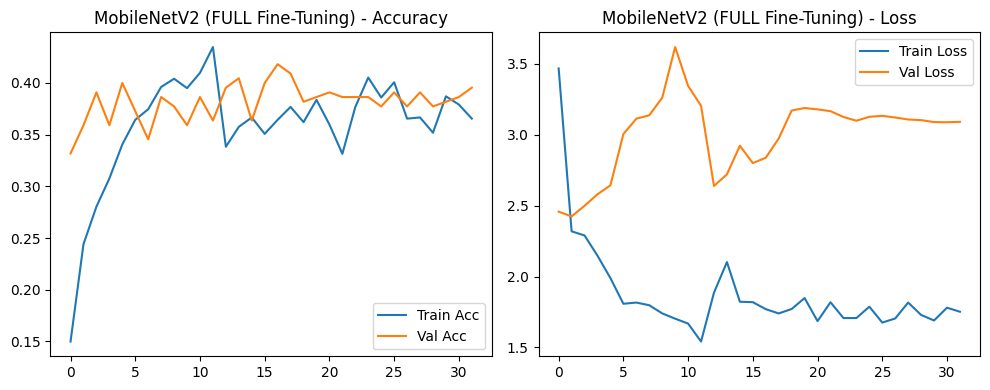

In [23]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- IMPORT MODEL YANG SUDAH KITA PILIH ---
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input # <-- PREPROCESSING [-1, 1]
# -------------------------

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
from sklearn.utils import class_weight # <-- IMPORT WAJIB

# ======================================================
# 🔧 PATH FIXER & DATA GENERATOR
# (Tidak ada perubahan, pipeline ini sudah benar)
# ======================================================
def fix_data_generators(train_df, base_path):
    print(f"📁 Base path: {base_path}")
    label_col = [c for c in train_df.columns if "label" in c.lower() or "class" in c.lower()][0]
    image_col = [c for c in train_df.columns if "file" in c.lower() or "image" in c.lower() or "path" in c.lower()][0]
    train_df[label_col] = train_df[label_col].astype(str).str.strip().str.title()

    def find_path(fname):
        clean = os.path.basename(str(fname))
        for folder in ["train", "images", "data", "dataset", ""]:
            path = os.path.join(base_path, folder, clean)
            if os.path.exists(path):
                return path
        return None

    train_df["full_path"] = train_df[image_col].apply(find_path)
    valid_df = train_df[train_df["full_path"].notna()].copy()
    print(f"✅ Found {len(valid_df)}/{len(train_df)} valid images")

    # --- GUNAKAN PREPROCESSING MOBILENETV2 ---
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input, # <-- PREPROCESSING BARU! [-1, 1]
        validation_split=0.2,
        rotation_range=25,       # <-- Augmentasi kuat
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input, # <-- PREPROCESSING BARU!
        validation_split=0.2
    )
    
    TARGET_SIZE = (224, 224)

    train_gen = train_datagen.flow_from_dataframe(
        valid_df,
        x_col="full_path",
        y_col=label_col,
        target_size=TARGET_SIZE,
        class_mode="categorical",
        batch_size=16, 
        subset="training",
        shuffle=True,
        seed=42
    )

    val_gen = val_datagen.flow_from_dataframe(
        valid_df,
        x_col="full_path",
        y_col=label_col,
        target_size=TARGET_SIZE,
        class_mode="categorical",
        batch_size=16,
        subset="validation",
        shuffle=False,
        seed=42
    )
    
    print(f"🎯 Classes found: {len(train_gen.class_indices)}")
    
    # --- PERHITUNGAN CLASS WEIGHT (WAJIB) ---
    y_train = train_gen.classes
    class_labels = np.unique(y_train)
    weights = class_weight.compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
    class_weights_dict = dict(zip(class_labels, weights))
    print(f"⚖️ Class Weights Dihitung:")
    print(class_weights_dict)
    # ---------------------------------
    
    X_batch, y_batch = next(iter(train_gen))
    print(f"\nVerifikasi Batch Data:")
    print(f"  Bentuk gambar (shape): {X_batch.shape}")
    print(f"  Nilai piksel min: {X_batch.min():.2f}, max: {X_batch.max():.2f}") # <-- HARUS [-1, 1]
    
    return train_gen, val_gen, class_weights_dict

# ======================================================
# 🚀 TRANSFER LEARNING MODEL
# (Head Kuat, tidak ada perubahan)
# ======================================================
def create_transfer_model(num_classes, input_shape=(224, 224, 3)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False # Wajib bekukan di awal

    # --- HEAD KUAT (DENGAN REGULARISASI MAX) ---
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x) # Dropout 50% 
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=output)
    return model, base_model

# ======================================================
# 🧠 FUNGSI TRAINING (STRATEGI BARU!)
# ======================================================
def train_model(train_df, base_path):
    print("🚀 INITIALIZING TRAINING (MobileNetV2 - FULL FINE-TUNING STRATEGY)...")
    
    train_gen, val_gen, class_weights = fix_data_generators(train_df, base_path)
    num_classes = len(train_gen.class_indices)
    
    model, base_model = create_transfer_model(num_classes=num_classes)

    # --- STAGE 1: FEATURE EXTRACTION (WARM-UP HEAD) ---
    print("\n--- 🧠 STAGE 1: FEATURE EXTRACTION (WARM-UP) ---")
    model.compile(
        optimizer=AdamW(learning_rate=1e-3),
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    model.summary()

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, mode='max', verbose=1)
    
    history_head = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=30, 
        callbacks=[early_stopping],
        class_weight=class_weights, 
        verbose=1
    )
    
    print("\n✅ STAGE 1 COMPLETE!")
    val_loss_s1, val_acc_s1 = model.evaluate(val_gen, verbose=0)
    print(f"✅ Accuracy after Stage 1: {val_acc_s1:.4f}")

    if val_acc_s1 < 0.2: 
        print(f"❌ Akurasi Stage 1 ({val_acc_s1:.4f}) sangat rendah. Cek data Anda.")
        return model, history_head, train_gen, val_gen

    # --- 🔥 STAGE 2: FULL FINE-TUNING (STRATEGI BARU) 🔥 ---
    print("\n--- 🔥 STAGE 2: FULL FINE-TUNING (Unfreezing ALL layers) ---")
    
    # --- PERUBAHAN #1: CAIRKAN SELURUH MODEL ---
    base_model.trainable = True
    print(f"Total layers in base_model: {len(base_model.layers)}")
    
    # --- PERUBAHAN #2: WAJIB BEKUKAN SEMUA LAYER BATCH NORM ---
    # Ini sangat penting untuk fine-tuning
    frozen_bn_count = 0
    for layer in base_model.layers:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = False
            frozen_bn_count += 1
    print(f"✅ Frozen {frozen_bn_count} BatchNormalization layers.")
    
    # (Loop untuk -40 layer SEKARANG DIHAPUS)

    # --- PERUBAHAN #3: COMPILE ULANG DENGAN LR SUPER KECIL ---
    model.compile(
        optimizer=AdamW(learning_rate=5e-6, weight_decay=1e-6), # <-- LR SUPER KECIL (5e-6)
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    model.summary() # Lihat summary, semua layer (kecuali BN) akan Trainable

    callbacks_ft = [
        EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max', verbose=1), # <-- Kesabaran ekstra
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-7, verbose=1),
        ModelCheckpoint('mobilenetv2_batik_best_FULLTUNE.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1) # Nama file baru
    ]
    
    initial_epoch_ft = len(history_head.history['loss'])

    print("Training all layers slowly... Ini akan memakan waktu.")
    history_fine_tune = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=80, # Beri waktu yang panjang untuk belajar pelan-pelan
        callbacks=callbacks_ft,
        initial_epoch=initial_epoch_ft,
        class_weight=class_weights, # <-- TETAP PAKAI CLASS WEIGHT
        verbose=1
    )

    print("\n✅ TRAINING COMPLETE!")
    print("🔄 Loading best weights from mobilenetv2_batik_best_FULLTUNE.keras...")
    model.load_weights('mobilenetv2_batik_best_FULLTUNE.keras')
    
    val_loss_final, val_acc_final = model.evaluate(val_gen, verbose=0)
    print(f"🏆 Final Validation Accuracy (Best): {val_acc_final:.4f}")
    
    history_combined = combine_histories(history_head, history_fine_tune)
    plot_training_history(history_combined, "MobileNetV2 (FULL Fine-Tuning)")

    return model, history_combined, train_gen, val_gen

# ======================================================
# 📊 VISUALIZATION (DENGAN HELPER)
# (Tidak ada perubahan)
# ======================================================

def combine_histories(h1, h2):
    """Menggabungkan dua history training (untuk plot)."""
    history = {}
    for key in h1.history.keys():
        if key in h2.history:
             history[key] = h1.history[key] + h2.history[key]
    return history

def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(10,4))
    
    if 'accuracy' in history:
        plt.subplot(1,2,1)
        plt.plot(history['accuracy'], label='Train Acc')
        plt.plot(history['val_accuracy'], label='Val Acc')
        plt.title(f"{title} - Accuracy")
        plt.legend()
    
    if 'loss' in history:
        plt.subplot(1,2,2)
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.title(f"{title} - Loss")
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
# ======================================================
# 🏁 MAIN EXECUTION
# (Ada perbaikan typo 'base_pa' -> 'base_path')
# ======================================================
if 'train_df' in globals() and train_df is not None:
    base_path = r"C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025"
    train_model(train_df, base_path) # <-- Perbaikan Typo
else:
    print("❌ train_df not found! Please load your train CSV first.")

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tqdm import tqdm

# ======================================================
# SETUP PATH
# ======================================================
base_path = r"C:\Users\Elsie\OneDrive\Desktop\DEEPLEARNING\untar-deep-learning-course-1-2-gj-2526\data-batik-2025"
model_path = r"C:\GitHub\web\DL_Batik-Image-Classification\mobilenetv2_batik_best_FULLTUNE.keras"

# ======================================================
# LOAD CSV DAN MODEL
# ======================================================
try:
    test_df = pd.read_csv("C:/Users/Elsie/OneDrive/Desktop/DEEPLEARNING/untar-deep-learning-course-1-2-gj-2526/test.csv")
    model = load_model(model_path)
    print("✅ Model loaded successfully!")
    model.summary() # Tambahan: Lihat arsitektur model
except Exception as e:
    print(f"❌ Error loading model or CSV: {e}")
    exit()

# ======================================================
# BUAT FULL PATH GAMBAR TEST
# ======================================================
def find_test_path(fname):
    clean = os.path.basename(str(fname))
    # Pastikan untuk mencari di dalam folder test
    for folder in ["test", "images", "data", "dataset", ""]:
        path = os.path.join(base_path, folder, clean)
        if os.path.exists(path):
            return path
    return None

test_df["full_path"] = test_df["filename"].apply(find_test_path)
test_df = test_df[test_df["full_path"].notna()]
print(f"✅ Found {len(test_df)} valid test images")

if len(test_df) == 0:
    raise ValueError("❌ Tidak ada gambar test yang ditemukan. Cek kembali base_path dan nama folder test.")

# ======================================================
# DATA GENERATOR UNTUK PREDIKSI (DIPERBAIKI)
# ======================================================
# PENTING:
# Model EfficientNet (B0, B1, B2, dll) dari keras.applications
# sudah punya layer rescaling di dalamnya. JADI JANGAN RESCALE LAGI.
test_datagen = ImageDataGenerator() # <-- TANPA RESCALE

# --- 🔥 PERBAIKAN UTAMA ADA DI SINI 🔥 ---
# Model Anda 'efficientnetB0_batik_best.keras' adalah B0,
# yang dilatih pada ukuran (224, 224).
TARGET_SIZE_B0 = (224, 224) 
# ----------------------------------------

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="full_path",
    y_col=None, # Tidak ada label y untuk data test
    target_size=TARGET_SIZE_B0, # <-- GUNAKAN UKURAN YANG BENAR
    class_mode=None, # Penting untuk data test
    batch_size=32,   # Batch size bisa disesuaikan, 32 sudah bagus
    shuffle=False    # JANGAN di-shuffle agar urutan prediksi sesuai
)

# ======================================================
# PREDIKSI
# ======================================================
print("🚀 Predicting test data...")
pred_probs = model.predict(test_gen, verbose=1)
pred_labels = np.argmax(pred_probs, axis=1)

# ======================================================
# MAPPING LABEL DAN SIMPAN CSV
# ======================================================
# PENTING: Urutan label ini HARUS SAMA PERSIS dengan urutan
# yang dipelajari model saat training (biasanya urutan abjad).
label_map = sorted([
    'Aseman', 'Bledak', 'Gringsing', 'Gunung Ringgit', 'Kontemporer', 'Krecak',
    'Latohan', 'Naga', 'Sekar Jagat', 'Siang Malam', 'Tumpal', 'Unknown'
])

# Cek kesesuaian jumlah kelas
if len(label_map) != model.output_shape[-1]:
    print(f"⚠️ Warning: Jumlah kelas model ({model.output_shape[-1]}) tidak sama dengan label_map ({len(label_map)})!")
else:
    print("✅ Label map and model output shape match.")

# Ambil nama kelas berdasarkan indeks prediksi
pred_class_names = [label_map[i] for i in pred_labels]

# Buat DataFrame untuk submission
submission = pd.DataFrame({
    "id": test_df["id"],
    "label": pred_class_names
})

# Simpan ke CSV
submission.to_csv("submission5.csv", index=False)
print("\n✅ Predictions saved to submission5.csv")
print("Submission file head:")
print(submission.head())

✅ Model loaded successfully!


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 8,637,926 (32.95 MB)

 Trainable params: 2,855,372 (10.89 MB)

 Non-trainable params: 71,808 (280.50 KB)

 Optimizer params: 5,710,746 (21.78 MB)

✅ Found 741 valid test images
Found 741 validated image filenames.
🚀 Predicting test data...


c:\Users\Elsie\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 336ms/step
✅ Label map and model output shape match.

✅ Predictions saved to submission4.csv
Submission file head:
   id    label
0   0  Unknown
1   1     Naga
2   2  Unknown
3   3     Naga
4   4     Naga
